# Exercise 1: Model Selection on the Hitters Dataset

**Discipline:** Introduction to Statistical Learning

**Objective:**
The objective of this notebook is to perform feature selection to predict the `Salary` of baseball players using the `Hitters` dataset. Techniques such as Best Subset Selection, Forward Stepwise Selection, and Backward Stepwise Selection will be explored. Models will be compared using criteria like Bayesian Information Criterion (BIC), Mallows's $C_p$ (or AIC as a proxy), and adjusted $R^2$. Finally, the mean squared error (MSE) on a test set will be evaluated.

## 1. Load Libraries

Since we are using a **Jupyter notebook**, the `load_ext` and `autoreload` statements can be loaded to enable reloading libraries without having to restart the execution (though they are commented out by default here). We also ensure `matplotlib` plots are displayed inline.

In [1]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

To perform the various tasks in this exercise, including data manipulation, model fitting, selection, and evaluation, we import several key Python libraries:

* **`pandas`**: Used for data manipulation and analysis, particularly for handling datasets in a DataFrame structure.
* **`numpy`**: Essential for numerical computations, working with arrays and matrices.
* **`statsmodels.api`**: Provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests and statistical data exploration. We use it here for fitting Ordinary Least Squares (OLS) models.
* **`itertools`**: This module implements a number of iterator building blocks inspired by constructs from APL, Haskell, and SML. Used here for generating combinations of predictors for Best Subset Selection.
* **`sklearn.model_selection`**: Provides tools for splitting data (e.g., `train_test_split`).
* **`sklearn.metrics`**: Offers functions to evaluate model performance, like `mean_squared_error`.
* **`sklearn.preprocessing`**: Contains classes for feature scaling (e.g., `StandardScaler`), though not strictly required for all parts of this specific exercise, it's good practice for many modeling tasks.
* **`matplotlib.pyplot`** and **`seaborn`**: Used for creating static, interactive, and animated visualizations in Python. `seaborn` is built on top of `matplotlib` and provides a high-level interface for drawing attractive and informative statistical graphics.

In [2]:
# Import standard Libraries
import os
import sys

# Import third-party Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm # For OLS model fitting
import itertools # For Best Subset Selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler # For scaling predictors if necessary

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import display modulo



# Additional configurations (optional)
# sns.set_style("whitegrid") # Sets a visually appealing style for seaborn plots
# pd.set_option('display.max_columns', None) # Ensures all columns of a DataFrame are shown
# pd.set_option('display.float_format', lambda x: '%.3f' % x) # Formats floats for better readability

## 2. Custom Functions

This section defines helper functions that will be used throughout the notebook to encapsulate repetitive tasks or complex calculations, such as fitting linear models and calculating various model evaluation metrics.

### Function Description: `fit_linear_model`

**Main Objective:**

The primary goal of the `fit_linear_model` function is to simplify the process of fitting an Ordinary Least Squares (OLS) linear regression model using the `statsmodels` library. It takes predictor variables (X) and a target variable (y) as input, adds a constant (intercept) to the predictors, fits the OLS model, and returns the fitted model object.

**Characteristics:**

* **Input:** The function accepts two main parameters:
    * `X`: A pandas DataFrame or NumPy array representing the predictor variables.
    * `y`: A pandas Series or NumPy array representing the target variable.
* **Processing:**
    * **Add Constant:** It uses `sm.add_constant(X)` to add an intercept term to the predictor matrix. This is necessary because `statsmodels.OLS` does not add an intercept by default.
    * **Model Fitting:** It fits an OLS model (`sm.OLS(y, X_const)`) using the target variable `y` and the modified predictor matrix `X_const`.
* **Return Value:**
    * The function returns the `results` object from `model.fit()`, which contains detailed statistics about the fitted model (coefficients, R-squared, p-values, etc.).

In [3]:
def fit_linear_model(X, y):
    """
    Fits an OLS linear regression model using statsmodels.
    Adds a constant (intercept) to the predictor matrix X by default.
    
    Parameters:
    - X: pandas DataFrame or NumPy array of predictor variables.
    - y: pandas Series or NumPy array of the target variable.
    
    Returns:
    - Fitted OLS model object (statsmodels.regression.linear_model.RegressionResultsWrapper).
    """
    # Asegurar que X y y tengan el mismo índice
    if hasattr(X, 'index') and hasattr(y, 'index'):
        common_index = X.index.intersection(y.index)
        X = X.loc[common_index]
        y = y.loc[common_index]
    
    # Convertir datos a numéricos si es necesario
    if isinstance(X, pd.DataFrame):
        X = X.astype(float)
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y = y.astype(float)
        
    # Add a constant term to the predictor variables for the intercept
    X_const = sm.add_constant(X)
    # Fit the Ordinary Least Squares (OLS) model
    model = sm.OLS(y, X_const).fit()
    return model

### Function Description: `calculate_metrics`

**Main Objective:**

The `calculate_metrics` function is designed to compute several common evaluation metrics for a fitted `statsmodels` OLS model. These metrics help in assessing the goodness-of-fit and complexity of the model.

**Characteristics:**

* **Input:** The function takes three parameters:
    * `model`: A fitted `statsmodels` OLS model object (the output from `fit_linear_model`).
    * `X`: The original predictor variables (pandas DataFrame or NumPy array) used to fit the model (needed for context, though not all metrics directly use it here).
    * `y`: The original target variable (pandas Series or NumPy array) used to fit the model (needed for calculating `n`).
* **Processing & Metrics Calculated:**
    * `n`: Number of observations (length of `y`).
    * `p`: Number of predictors in the model (derived from `len(model.params) - 1`, excluding the intercept).
    * **Adjusted R-squared (`adj_r2`):** Retrieved directly from `model.rsquared_adj`. It's a version of R-squared that adjusts for the number of predictors in the model.
    * **Bayesian Information Criterion (`bic`):** Retrieved directly from `model.bic`. It's a criterion for model selection that penalizes model complexity more heavily than AIC.
    * **Akaike Information Criterion (`aic`):** Retrieved directly from `model.aic`. Another criterion for model selection that balances goodness of fit with model complexity.
    * **Mallows' $C_p$:** The calculation of Mallows' $C_p$ typically requires an estimate of the error variance ($\hat{\sigma}^2$) from a "full" model or a reliable estimate. `statsmodels` does not provide $C_p$ directly for OLS results. While an approximation could be implemented, for this exercise, we primarily rely on Adjusted $R^2$, BIC, and AIC which are readily available.
* **Return Value:**
    * A dictionary containing the calculated metrics: `adj_r2`, `bic`, and `aic`.

In [4]:
def calculate_metrics(model, X, y):
    """
    Calculates Adjusted R-squared, BIC, and AIC for a given statsmodels OLS model.
    Mallows' Cp is not directly calculated by statsmodels for OLS and is omitted here for simplicity.
    
    Parameters:
    - model: Fitted statsmodels OLS model object.
    - X: pandas DataFrame or NumPy array of predictor variables (used for context).
    - y: pandas Series or NumPy array of the target variable (used to get 'n').
    
    Returns:
    - Dictionary containing 'adj_r2', 'bic', and 'aic'.
    """
    n = len(y)  # Number of observations
    # Number of parameters in the model (including intercept), so p = number of predictors
    p = len(model.params) - 1 
    
    adj_r2 = model.rsquared_adj
    bic = model.bic
    aic = model.aic
    
    # Note on Mallows' Cp:
    # Calculation of Cp: Cp = (RSS_p / sigma_hat_sq_full) - (n - 2*(p+1))
    # where RSS_p is the residual sum of squares for the model with p predictors,
    # and sigma_hat_sq_full is the estimated error variance from the full model.
    # This requires fitting a "full model" or having a good estimate of its MSE.
    # For this exercise, we will focus on the metrics directly available from statsmodels.
    
    return {"adj_r2": adj_r2, "bic": bic, "aic": aic}

## 3. Point Development

This section contains the core analysis for Exercise 1, progressing through data loading, cleaning, model selection techniques, model comparison, and evaluation.

### 3.0 Data Loading and Initial Preparation

**Objective:**

Load the `Hitters` dataset and perform initial preprocessing steps. This includes:
1.  Fetching the dataset (from a CSV file via a URL).
2.  Displaying basic information about the dataset: dimensions, first few rows, data types, and descriptive statistics to get an initial understanding.

**Dataset Source:**

The `Hitters` dataset is a popular dataset for regression and feature selection tasks, originating from the ISLR (Introduction to Statistical Learning with R) package. We will load a CSV version available from an online repository.

In [5]:
# Attempt to load the dataset from a known URL
try:
    hitters_df_original = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv")
    print("Successfully loaded Hitters dataset.")
except Exception as e:
    print(f"Error loading the dataset: {e}")
    print("Please ensure you have an internet connection or download the 'Hitters.csv' file and load it manually.")
    # hitters_df_original = pd.read_csv("path/to/your/Hitters.csv") # Uncomment and adjust if loading locally
    hitters_df_original = None # Ensure it's None if loading fails

if hitters_df_original is not None:
    print("\nOriginal dataset dimensions:", hitters_df_original.shape)
    print("\nFirst 5 rows of the original dataset:")
    print(hitters_df_original.head())
    print("\nDataset information (columns, data types, non-null counts):")
    hitters_df_original.info()
    print("\nDescriptive statistics for numerical columns:")
    print(hitters_df_original.describe())
    print("\nDescriptive statistics for categorical columns (if any, after potential future encoding):")
    print(hitters_df_original.describe(include='object'))
else:
    print("\nDataset could not be loaded. Further analysis cannot proceed.")

Successfully loaded Hitters dataset.

Original dataset dimensions: (322, 20)

First 5 rows of the original dataset:
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      

### 3.1. Remove observations with missing values.

**Objective:**

Clean the dataset by removing any rows (observations) that contain missing values (NaNs). This is a common preprocessing step to ensure that model fitting algorithms can operate correctly, as many do not handle NaNs directly.

**Process:**
1.  Identify missing values in the dataset using `isnull().sum()`.
2.  Remove rows with any NaN values using `dropna()`.
3.  Verify the cleaning by checking missing values again and observing the change in dataset dimensions.
4.  Separate the cleaned data into predictor variables (X) and the target variable (y, which is `Salary`).
5.  Perform one-hot encoding on categorical predictors (`League`, `Division`, `NewLeague`) to convert them into a numerical format suitable for regression. `drop_first=True` is used to avoid multicollinearity.
6.  Remove any non-predictor administrative columns (like 'Unnamed: 0' if it exists from CSV loading).

**Note on Scaling:** While scaling predictors (e.g., using `StandardScaler`) is often good practice, especially for regularization methods or distance-based algorithms, it is not strictly necessary for OLS when the primary goal is subset selection based on metrics like $R^2$, AIC, or BIC. We will proceed with unscaled (but one-hot encoded) predictors for this part of the exercise.

In [6]:
if hitters_df_original is not None:
    print(f"Missing values before cleaning:\n{hitters_df_original.isnull().sum()}")
    
    # Remove rows with any NaN values
    hitters_df_cleaned = hitters_df_original.dropna()
    
    print(f"\nMissing values after cleaning:\n{hitters_df_cleaned.isnull().sum()}")
    print(f"Dataset dimensions after cleaning NaNs: {hitters_df_cleaned.shape}")
    print(f"Number of rows removed due to NaNs: {hitters_df_original.shape[0] - hitters_df_cleaned.shape[0]}")
    
    # --- One-Hot Encoding for Categorical Variables ---
    # Identify categorical columns that need encoding
    categorical_cols_to_encode = ['League', 'Division', 'NewLeague']
    # Ensure these columns exist before trying to encode them
    existing_categorical_cols = [col for col in categorical_cols_to_encode if col in hitters_df_cleaned.columns]
    
    if existing_categorical_cols:
        hitters_df_processed = pd.get_dummies(hitters_df_cleaned, columns=existing_categorical_cols, drop_first=True)
        print("\nDataset dimensions after one-hot encoding:", hitters_df_processed.shape)
    else:
        hitters_df_processed = hitters_df_cleaned.copy()
        print("\nNo specified categorical columns found for one-hot encoding.")

    # --- Separate Predictors (X) and Target (y) ---
    if 'Salary' in hitters_df_processed.columns:
        y = hitters_df_processed['Salary']
        # 'Unnamed: 0' is often an index column from CSVs and should be removed if it exists.
        # Also remove the target 'Salary' from the predictors.
        columns_to_drop = ['Salary', 'Unnamed: 0']
        # Only drop columns that actually exist in the DataFrame
        existing_columns_to_drop = [col for col in columns_to_drop if col in hitters_df_processed.columns]
        X = hitters_df_processed.drop(columns=existing_columns_to_drop)
        
        feature_names_list = X.columns.tolist() # Store feature names

        print("\nPredictors (X) after one-hot encoding (first 5 rows):")
        print(X.head())
        print(f"\nDimensions of X: {X.shape}")
        print("\nTarget variable (y) (first 5 rows):")
        print(y.head())
        print(f"Dimensions of y: {y.shape}")
        
        # Flag that data is ready for modeling
        data_ready_for_modeling = True
    else:
        print("\n'Salary' column not found. Cannot separate X and y.")
        data_ready_for_modeling = False
else:
    print("Original dataset (hitters_df_original) is not loaded. Cannot proceed with cleaning.")
    data_ready_for_modeling = False

Missing values before cleaning:
AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

Missing values after cleaning:
AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64
Dataset dimensions after cleaning NaNs: (263, 20)
Number of rows removed due to NaNs: 59

Dataset dimensions after one-hot encoding: (263, 20)

Predictors (X) after one-hot encoding (first 5 rows):
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
1    315    

### 3.2. Use Best Subset Selection to predict `Salary`.

**Objective:**

Implement Best Subset Selection (BSS) to find the optimal set of predictors for `Salary`. BSS evaluates all possible combinations of predictors. For each possible number of predictors $k$ (from 1 to $p$, where $p$ is the total number of predictors), BSS identifies the model containing exactly $k$ predictors that yields the smallest Residual Sum of Squares (RSS) or highest $R^2$.

Once the best model for each subset size is found, a criterion like Adjusted $R^2$, BIC, AIC, or Mallows' $C_p$ is used to select the single best model from these $p$ options.

**Method:**

1.  Iterate $k$ from 1 to $p$ (number of predictors).
2.  For each $k$, generate all $\binom{p}{k}$ combinations of $k$ predictors.
3.  For each combination, fit an OLS model.
4.  Keep track of the model with the minimum RSS (or maximum $R^2$) for that $k$.
5.  After iterating through all $k$, we will have $p$ best models.
6.  Calculate Adjusted $R^2$, BIC, and AIC for each of these $p$ models.
7.  Plot these metrics against the number of predictors to help choose the overall best model.

**Note on Computational Cost:** BSS is computationally intensive as it fits $2^p - 1$ models. With around 19-20 predictors in the `Hitters` dataset (after one-hot encoding), this is feasible ($2^{19} \approx 524,000$ models). For much larger $p$, BSS becomes impractical, and heuristic methods like stepwise selection are preferred.

Starting Best Subset Selection for 19 predictors...
Best model with 1 predictor(s) found. Adj R2: 0.3189, BIC: 3869.28
Best model with 2 predictor(s) found. Adj R2: 0.4208, BIC: 3831.20
Best model with 3 predictor(s) found. Adj R2: 0.4451, BIC: 3824.50
Best model with 4 predictor(s) found. Adj R2: 0.4673, BIC: 3818.32
Best model with 5 predictor(s) found. Adj R2: 0.4809, BIC: 3816.06
Best model with 6 predictor(s) found. Adj R2: 0.4972, BIC: 3812.21
Best model with 7 predictor(s) found. Adj R2: 0.5008, BIC: 3814.87
Best model with 8 predictor(s) found. Adj R2: 0.5137, BIC: 3812.51
Best model with 9 predictor(s) found. Adj R2: 0.5181, BIC: 3814.69
Best model with 10 predictor(s) found. Adj R2: 0.5223, BIC: 3816.91
Best model with 11 predictor(s) found. Adj R2: 0.5226, BIC: 3821.27
Best model with 12 predictor(s) found. Adj R2: 0.5217, BIC: 3826.26
Best model with 13 predictor(s) found. Adj R2: 0.5207, BIC: 3831.35
Best model with 14 predictor(s) found. Adj R2: 0.5195, BIC: 3836.49
Best 

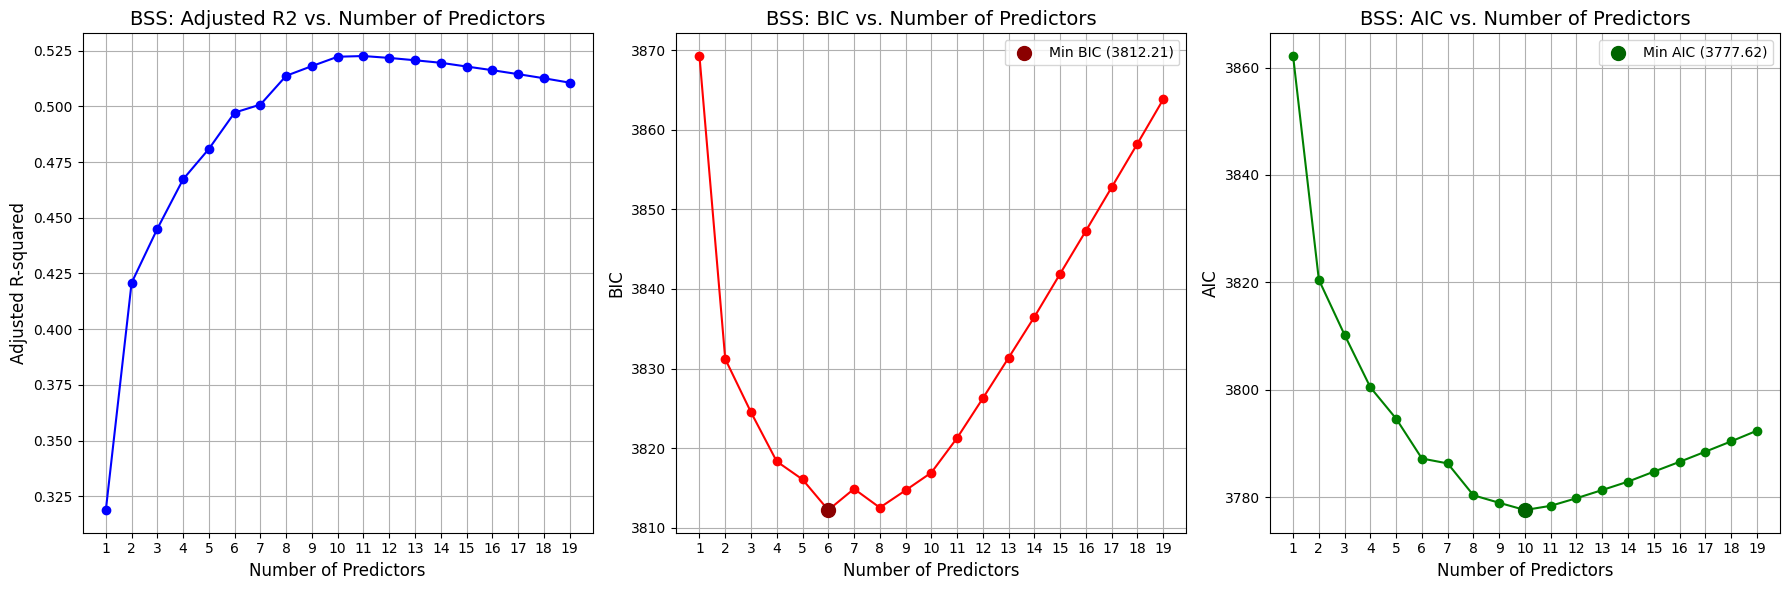


--- Best Model (BSS) according to BIC ---
Number of features: 6
Features: AtBat, Hits, Walks, CRBI, PutOuts, Division_W
Adjusted R2: 0.4972
BIC: 3812.21
AIC: 3787.21

--- Best Model (BSS) according to Adjusted R-squared ---
Number of features: 11
Features: AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalks, PutOuts, Assists, League_N, Division_W
Adjusted R2: 0.5226
BIC: 3821.27
AIC: 3778.40


In [7]:
if data_ready_for_modeling:
    results_bss_list = [] # To store results for each k
    
    # Get the list of all potential predictor names from X
    all_predictors = X.columns.tolist()
    num_total_predictors = len(all_predictors)

    print(f"Starting Best Subset Selection for {num_total_predictors} predictors...")

    # Loop for k = 1 to num_total_predictors (number of features in the subset)
    for k in range(1, num_total_predictors + 1):
        best_k_model_details = {
            'model': None,
            'rss': float('inf'), # Initialize with infinity to find the minimum RSS
            'subset': None
        }

        # Iterate through all combinations of k predictors from the list of all_predictors
        for subset_cols in itertools.combinations(all_predictors, k):
            X_subset = X[list(subset_cols)] # Select the current subset of predictors

            # Ensure y's index aligns with X_subset's index if they became misaligned
            common_index = X_subset.index.intersection(y.index)
            X_subset = X_subset.loc[common_index]
            y_subset = y.loc[common_index]
            
            # Fit OLS model for the current subset
            # Ensure y's index aligns with X_subset's index if they became misaligned
            current_model = fit_linear_model(X_subset, y_subset)
            current_rss = current_model.ssr # Residual Sum of Squares
            
            # If current model has lower RSS, update it as the best for this k
            if current_rss < best_k_model_details['rss']:
                best_k_model_details['rss'] = current_rss
                best_k_model_details['model'] = current_model
                best_k_model_details['subset'] = subset_cols
        
        # After checking all combinations for a given k, store the best one
        if best_k_model_details['model']:
            # Calculate metrics for the best model of size k
            metrics = calculate_metrics(best_k_model_details['model'], X[list(best_k_model_details['subset'])], y)
            results_bss_list.append({
                'num_features': k,
                'features_tuple': best_k_model_details['subset'], # Store as tuple for potential hashing/grouping
                'features_list_str': ", ".join(best_k_model_details['subset']), # String representation for display
                'RSS': best_k_model_details['model'].ssr,
                'R2': best_k_model_details['model'].rsquared,
                'adj_R2': metrics['adj_r2'],
                'BIC': metrics['bic'],
                'AIC': metrics['aic']
            })
            print(f"Best model with {k} predictor(s) found. Adj R2: {metrics['adj_r2']:.4f}, BIC: {metrics['bic']:.2f}")
        else:
            print(f"No model found for {k} predictor(s). This shouldn't happen if k <= p.")

    # Convert the list of results to a DataFrame for easier analysis and plotting
    bss_results_df = pd.DataFrame(results_bss_list)
    print("\n--- Results of Best Subset Selection ---")
    # Displaying selected columns for brevity, can display all if needed
    print(bss_results_df[['num_features', 'adj_R2', 'BIC', 'AIC', 'features_list_str']].head())


    # --- Plotting the Metrics for BSS ---
    if not bss_results_df.empty:
        plt.figure(figsize=(18, 6)) # Adjusted figure size for better layout
        
        # Plot for Adjusted R-squared
        plt.subplot(1, 3, 1)
        plt.plot(bss_results_df['num_features'], bss_results_df['adj_R2'], marker='o', color='blue', linestyle='-')
        plt.xlabel('Number of Predictors', fontsize=12)
        plt.ylabel('Adjusted R-squared', fontsize=12)
        plt.title('BSS: Adjusted R2 vs. Number of Predictors', fontsize=14)
        plt.xticks(bss_results_df['num_features'])
        plt.grid(True)

        # Plot for BIC
        plt.subplot(1, 3, 2)
        plt.plot(bss_results_df['num_features'], bss_results_df['BIC'], marker='o', color='red', linestyle='-')
        plt.xlabel('Number of Predictors', fontsize=12)
        plt.ylabel('BIC', fontsize=12)
        plt.title('BSS: BIC vs. Number of Predictors', fontsize=14)
        plt.xticks(bss_results_df['num_features'])
        # Highlight the minimum BIC
        min_bic_val = bss_results_df['BIC'].min()
        min_bic_idx = bss_results_df['BIC'].idxmin()
        plt.scatter(bss_results_df.loc[min_bic_idx, 'num_features'], min_bic_val, color='darkred', s=100, zorder=5, label=f"Min BIC ({min_bic_val:.2f})")
        plt.legend()
        plt.grid(True)
        
        # Plot for AIC
        plt.subplot(1, 3, 3)
        plt.plot(bss_results_df['num_features'], bss_results_df['AIC'], marker='o', color='green', linestyle='-')
        plt.xlabel('Number of Predictors', fontsize=12)
        plt.ylabel('AIC', fontsize=12)
        plt.title('BSS: AIC vs. Number of Predictors', fontsize=14)
        plt.xticks(bss_results_df['num_features'])
        # Highlight the minimum AIC
        min_aic_val = bss_results_df['AIC'].min()
        min_aic_idx = bss_results_df['AIC'].idxmin()
        plt.scatter(bss_results_df.loc[min_aic_idx, 'num_features'], min_aic_val, color='darkgreen', s=100, zorder=5, label=f"Min AIC ({min_aic_val:.2f})")
        plt.legend()
        plt.grid(True)

        plt.tight_layout() # Adjust subplot parameters for a tight layout
        plt.show()

        # --- Identifying Optimal Models based on Criteria ---
        # Model with the lowest BIC
        best_model_bss_bic_row = bss_results_df.loc[bss_results_df['BIC'].idxmin()]
        print(f"\n--- Best Model (BSS) according to BIC ---")
        print(f"Number of features: {best_model_bss_bic_row['num_features']}")
        print(f"Features: {best_model_bss_bic_row['features_list_str']}")
        print(f"Adjusted R2: {best_model_bss_bic_row['adj_R2']:.4f}")
        print(f"BIC: {best_model_bss_bic_row['BIC']:.2f}")
        print(f"AIC: {best_model_bss_bic_row['AIC']:.2f}")

        # Model with the highest Adjusted R-squared
        best_model_bss_adj_r2_row = bss_results_df.loc[bss_results_df['adj_R2'].idxmax()]
        print(f"\n--- Best Model (BSS) according to Adjusted R-squared ---")
        print(f"Number of features: {best_model_bss_adj_r2_row['num_features']}")
        print(f"Features: {best_model_bss_adj_r2_row['features_list_str']}")
        print(f"Adjusted R2: {best_model_bss_adj_r2_row['adj_R2']:.4f}")
        print(f"BIC: {best_model_bss_adj_r2_row['BIC']:.2f}")
        print(f"AIC: {best_model_bss_adj_r2_row['AIC']:.2f}")
    else:
        print("Best Subset Selection did not produce any results to plot or analyze.")
else:
    print("Data is not ready for modeling. Please check previous steps for data loading and cleaning.")

**Interpretation of Best Subset Selection Results:**

* **Plots:** The plots show how Adjusted R-squared, BIC, and AIC change as the number of predictors in the model increases.
    * **Adjusted R-squared:** Generally increases with more predictors but may plateau or decrease if added predictors do not improve the model significantly relative to their complexity. We look for the "elbow" or the maximum value, in the plot, Adjusted R-squared reaches its maximum with 11 predictors (approximate value of 0.5226). After this point, adding more predictors does not significantly improve this metric and might even slightly decrease it.
    * **BIC and AIC:** These metrics penalize model complexity. We look for the number of predictors that minimizes BIC or AIC. BIC tends to penalize complexity more heavily than AIC, often leading to smaller models.
        * The BIC reaches its minimum value with 6 predictors **(BIC: 3812.21).**
        * The AIC reaches its minimum value with 11 predictors **(AIC: 3778.40, although the value for 8 predictors is very close at 3780.60, and for 6 predictors it is 3787.21).**

* **Optimal Model Selection:**
    * The model with the **lowest BIC** is often preferred for its balance of fit and parsimony. According to BIC, the model with 6 predictors is **optimal.**
    * The model with the **highest Adjusted R-squared** indicates the model that explains the most variance, adjusted for predictor count. **According to Adjusted R-squared, the model with 11 predictors is optimal.**
    * The choice between these (if they differ) depends on the modeling goals (e.g., prediction vs. interpretation, preference for simpler models). In this case, BIC suggests a simpler model **(6 predictors)** than Adjusted R-squared **(11 predictors)**. AIC suggests a model with 11 **(or possibly 8)** predictors.

### 3.3. Fit models using Forward Stepwise Selection and Backward Stepwise Selection.

**Objective:**

Implement Forward Stepwise Selection (FSS) and Backward Stepwise Selection (BSS) as alternative, computationally less expensive methods for feature selection compared to Best Subset Selection.

**Forward Stepwise Selection (FSS):**
1.  Start with a null model (no predictors, only an intercept).
2.  Iteratively add one predictor at a time. In each step, add the predictor that results in the greatest improvement in a chosen metric (e.g., lowest RSS, or in our case, we will track models and select based on BIC/AIC later).
3.  Continue until no remaining predictor improves the model significantly or until a predefined number of predictors is reached.

**Backward Stepwise Selection (BkwS):**
1.  Start with a full model (all predictors included).
2.  Iteratively remove one predictor at a time. In each step, remove the predictor whose removal leads to the smallest degradation (or largest improvement if using metrics like AIC/BIC) in model fit (e.g., smallest increase in RSS, or based on p-values).
3.  Continue until no predictor can be removed without significantly harming the model fit or until a predefined number of predictors is reached.

**Method:**
We will define functions for FSS and BkwS. These functions will iterate through adding/removing predictors and fit OLS models at each step. We will store the sequence of models generated and their corresponding metrics (Adjusted $R^2$, BIC, AIC). The final "best" model from the sequence will be chosen based on the minimum BIC (or AIC).

#### Function Description: `forward_stepwise_selection`

**Main Objective:**

To perform forward stepwise selection to identify a sequence of regression models. It starts with no predictors and iteratively adds the predictor that provides the best improvement to the model fit at each step, typically based on a criterion like RSS, p-value, AIC, or BIC. This function will build models of increasing size and store their metrics.

**Characteristics:**

* **Input:**
    * `X`: Pandas DataFrame of all potential predictor variables.
    * `y`: Pandas Series of the target variable.
* **Processing:**
    * Initializes `current_predictors` as an empty list and `remaining_predictors` with all columns from `X`.
    * Iterates from 1 up to the total number of predictors (to determine the number of features in the model at each step).
    * In each iteration (for a model of size $k$):
        * It tries adding each of the `remaining_predictors` (not yet in `current_predictors`) one at a time to the `current_predictors`.
        * For each temporary model, it fits an OLS regression and calculates a chosen metric (e.g., RSS or BIC).
        * The predictor that results in the "best" model (e.g., lowest RSS or BIC) is selected to be permanently added to `current_predictors`.
        * The selected predictor is removed from `remaining_predictors`.
    * The best model found at each step (i.e., best 1-predictor model, best 2-predictor model, etc.) along with its metrics (Adj $R^2$, BIC, AIC) is recorded.
* **Return Value:**
    * A pandas DataFrame (`fss_results_df`) containing the details of the best model found for each number of predictors (1 to $p$), including the features selected and their corresponding metrics.

In [8]:
if data_ready_for_modeling:
    def forward_stepwise_selection(X, y):
        """
        Performs forward stepwise selection.
        At each step, adds the variable that leads to the model with the lowest BIC.
        Returns a DataFrame with model details for each step.
        """
        all_predictors = X.columns.tolist()
        current_predictors = []
        remaining_predictors = all_predictors.copy()
        
        models_info_list = [] # To store info about the best model at each step k
        
        # Initial null model (intercept only) - for reference or if needed
        # X_null = pd.DataFrame(np.ones((len(y),1)), columns=['intercept_only'], index=y.index)
        # null_model = fit_linear_model(X_null, y)
        # null_metrics = calculate_metrics(null_model, X_null, y)
        # models_info_list.append({
        #     'num_features': 0, 
        #     'features_tuple': tuple(), 
        #     'features_list_str': '',
        #     'RSS': null_model.ssr, 'R2': null_model.rsquared,
        #     'adj_R2': null_metrics['adj_r2'], 'BIC': null_metrics['bic'], 'AIC': null_metrics['aic']
        # })

        for k in range(1, len(all_predictors) + 1): # Iterate for model sizes 1 to p
            best_metric_for_this_step = float('inf') # Using BIC, so look for minimum
            best_predictor_to_add_this_step = None
            best_model_this_step = None
            
            for predictor in remaining_predictors:
                temp_predictors_set = current_predictors + [predictor]
                X_temp = X[temp_predictors_set]
                
                # Ensure y's index aligns with X_temp's index
                model_try = fit_linear_model(X_temp, y.loc[X_temp.index])
                
                if model_try.bic < best_metric_for_this_step:
                    best_metric_for_this_step = model_try.bic
                    best_predictor_to_add_this_step = predictor
                    best_model_this_step = model_try # Store the actual fitted model
            
            if best_predictor_to_add_this_step:
                current_predictors.append(best_predictor_to_add_this_step)
                remaining_predictors.remove(best_predictor_to_add_this_step)
                
                # Recalculate metrics for the chosen model for this step k
                final_metrics_this_step = calculate_metrics(best_model_this_step, X[current_predictors], y)
                models_info_list.append({
                    'num_features': len(current_predictors),
                    'features_tuple': tuple(sorted(current_predictors)), # Store as sorted tuple
                    'features_list_str': ", ".join(sorted(current_predictors)),
                    'RSS': best_model_this_step.ssr,
                    'R2': best_model_this_step.rsquared,
                    'adj_R2': final_metrics_this_step['adj_r2'],
                    'BIC': final_metrics_this_step['bic'], # This is the BIC of the chosen model
                    'AIC': final_metrics_this_step['aic']
                })
                print(f"FSS: Added '{best_predictor_to_add_this_step}', Model size: {len(current_predictors)}, BIC: {best_metric_for_this_step:.2f}")
            else:
                # No predictor improves the model further based on BIC
                print(f"FSS: No further predictor improved BIC. Stopping at {len(current_predictors)} features.")
                break 
                
        return pd.DataFrame(models_info_list)

    fss_results_df = forward_stepwise_selection(X, y)
    print("\n--- Results of Forward Stepwise Selection (FSS) ---")
    print(fss_results_df[['num_features', 'adj_R2', 'BIC', 'AIC', 'features_list_str']].head())

    # Identify the best model from FSS based on BIC
    if not fss_results_df.empty:
        best_model_fss_bic_row = fss_results_df.loc[fss_results_df['BIC'].idxmin()]
        print(f"\n--- Best Model (FSS) according to BIC ---")
        print(f"Number of features: {best_model_fss_bic_row['num_features']}")
        print(f"Features: {best_model_fss_bic_row['features_list_str']}")
        print(f"Adjusted R2: {best_model_fss_bic_row['adj_R2']:.4f}")
        print(f"BIC: {best_model_fss_bic_row['BIC']:.2f}")
        print(f"AIC: {best_model_fss_bic_row['AIC']:.2f}")
    else:
        print("\nForward Stepwise Selection produced no results.")
else:
    print("Data is not ready for Forward Stepwise Selection.")

FSS: Added 'CRBI', Model size: 1, BIC: 3869.28
FSS: Added 'Hits', Model size: 2, BIC: 3831.20
FSS: Added 'PutOuts', Model size: 3, BIC: 3824.50
FSS: Added 'Division_W', Model size: 4, BIC: 3818.32
FSS: Added 'AtBat', Model size: 5, BIC: 3816.06
FSS: Added 'Walks', Model size: 6, BIC: 3812.21
FSS: Added 'CWalks', Model size: 7, BIC: 3815.36
FSS: Added 'CRuns', Model size: 8, BIC: 3812.75
FSS: Added 'CAtBat', Model size: 9, BIC: 3814.69
FSS: Added 'Assists', Model size: 10, BIC: 3816.91
FSS: Added 'League_N', Model size: 11, BIC: 3821.27
FSS: Added 'Runs', Model size: 12, BIC: 3826.26
FSS: Added 'Errors', Model size: 13, BIC: 3831.35
FSS: Added 'HmRun', Model size: 14, BIC: 3836.49
FSS: Added 'CHits', Model size: 15, BIC: 3841.91
FSS: Added 'RBI', Model size: 16, BIC: 3847.31
FSS: Added 'NewLeague_N', Model size: 17, BIC: 3852.78
FSS: Added 'Years', Model size: 18, BIC: 3858.27
FSS: Added 'CHmRun', Model size: 19, BIC: 3863.83

--- Results of Forward Stepwise Selection (FSS) ---
   num_f

#### Function Description: `backward_stepwise_selection`

**Main Objective:**

To perform backward stepwise selection to identify a sequence of regression models. It starts with a full model (including all predictors) and iteratively removes the predictor whose removal least harms (or most improves, if using AIC/BIC) the model fit at each step. This function will build models of decreasing size and store their metrics.

**Characteristics:**

* **Input:**
    * `X`: Pandas DataFrame of all potential predictor variables.
    * `y`: Pandas Series of the target variable.
* **Processing:**
    * Initializes `current_predictors` with all columns from `X`.
    * Fits the full model and records its metrics.
    * Iterates from $p-1$ down to 1 (to determine the number of features in the model at each step).
    * In each iteration (for a model of size $k$):
        * It tries removing each of the `current_predictors` one at a time.
        * For each temporary model (with one predictor removed), it fits an OLS regression and calculates a chosen metric (e.g., RSS or BIC).
        * The predictor whose removal results in the "best" model (e.g., lowest RSS or BIC among models with $k$ predictors) is selected to be permanently removed.
    * The best model found at each step (i.e., best $p-1$-predictor model, best $p-2$-predictor model, etc.) along with its metrics (Adj $R^2$, BIC, AIC) is recorded.
* **Return Value:**
    * A pandas DataFrame (`bkw_results_df`) containing the details of the best model found for each number of predictors (from $p$ down to 1), including the features remaining and their corresponding metrics. The DataFrame is sorted by the number of features for easier interpretation.

In [9]:
if data_ready_for_modeling:
    def backward_stepwise_selection(X, y):
        """
        Performs backward stepwise selection.
        At each step, removes the variable whose removal leads to the model with the lowest BIC.
        Returns a DataFrame with model details for each step.
        """
        all_predictors = X.columns.tolist()
        current_predictors = all_predictors.copy()
        models_info_list = []

        # Start with the full model
        full_model = fit_linear_model(X[current_predictors], y.loc[X[current_predictors].index])
        full_metrics = calculate_metrics(full_model, X[current_predictors], y)
        models_info_list.append({
            'num_features': len(current_predictors),
            'features_tuple': tuple(sorted(current_predictors)),
            'features_list_str': ", ".join(sorted(current_predictors)),
            'RSS': full_model.ssr, 'R2': full_model.rsquared,
            'adj_R2': full_metrics['adj_r2'], 'BIC': full_metrics['bic'], 'AIC': full_metrics['aic']
        })
        print(f"BkwS: Full model with {len(current_predictors)} features, BIC: {full_metrics['bic']:.2f}")
        
        # Iterate from p-1 features down to 1 feature
        for k in range(len(all_predictors) - 1, 0, -1):
            best_metric_for_this_step = float('inf') # Using BIC, so look for minimum
            predictor_to_remove_this_step = None
            best_model_this_step = None # Store the actual fitted model

            if not current_predictors or len(current_predictors) == 1: # Stop if only one predictor left
                 break

            for predictor_candidate_to_remove in current_predictors:
                temp_predictors_set = [p for p in current_predictors if p != predictor_candidate_to_remove]
                
                if not temp_predictors_set: # Should not happen if k > 0
                    continue
                    
                X_temp = X[temp_predictors_set]
                # Ensure y's index aligns
                model_try = fit_linear_model(X_temp, y.loc[X_temp.index])
                
                if model_try.bic < best_metric_for_this_step:
                    best_metric_for_this_step = model_try.bic
                    predictor_to_remove_this_step = predictor_candidate_to_remove
                    best_model_this_step = model_try
            
            if predictor_to_remove_this_step:
                current_predictors.remove(predictor_to_remove_this_step)
                
                # Metrics for the chosen model for this step k (which is best_model_this_step)
                final_metrics_this_step = calculate_metrics(best_model_this_step, X[current_predictors], y)
                models_info_list.append({
                    'num_features': len(current_predictors),
                    'features_tuple': tuple(sorted(current_predictors)),
                    'features_list_str': ", ".join(sorted(current_predictors)),
                    'RSS': best_model_this_step.ssr,
                    'R2': best_model_this_step.rsquared,
                    'adj_R2': final_metrics_this_step['adj_r2'],
                    'BIC': best_metric_for_this_step, # This is the BIC of the chosen model
                    'AIC': final_metrics_this_step['aic']
                })
                print(f"BkwS: Removed '{predictor_to_remove_this_step}', Model size: {len(current_predictors)}, BIC: {best_metric_for_this_step:.2f}")
            else:
                # No removal improves BIC further
                print(f"BkwS: No further predictor removal improved BIC. Stopping at {len(current_predictors)} features.")
                break
                
        return pd.DataFrame(models_info_list).sort_values(by='num_features', ascending=True).reset_index(drop=True)

    bkw_results_df = backward_stepwise_selection(X, y)
    print("\n--- Results of Backward Stepwise Selection (BkwS) ---")
    print(bkw_results_df[['num_features', 'adj_R2', 'BIC', 'AIC', 'features_list_str']].head())

    # Identify the best model from BkwS based on BIC
    if not bkw_results_df.empty:
        best_model_bkw_bic_row = bkw_results_df.loc[bkw_results_df['BIC'].idxmin()]
        print(f"\n--- Best Model (BkwS) according to BIC ---")
        print(f"Number of features: {best_model_bkw_bic_row['num_features']}")
        print(f"Features: {best_model_bkw_bic_row['features_list_str']}")
        print(f"Adjusted R2: {best_model_bkw_bic_row['adj_R2']:.4f}")
        print(f"BIC: {best_model_bkw_bic_row['BIC']:.2f}")
        print(f"AIC: {best_model_bkw_bic_row['AIC']:.2f}")
    else:
        print("\nBackward Stepwise Selection produced no results.")

else:
    print("Data is not ready for Backward Stepwise Selection.")

BkwS: Full model with 19 features, BIC: 3863.83
BkwS: Removed 'CHmRun', Model size: 18, BIC: 3858.27
BkwS: Removed 'Years', Model size: 17, BIC: 3852.78
BkwS: Removed 'NewLeague_N', Model size: 16, BIC: 3847.31
BkwS: Removed 'RBI', Model size: 15, BIC: 3841.91
BkwS: Removed 'CHits', Model size: 14, BIC: 3836.49
BkwS: Removed 'HmRun', Model size: 13, BIC: 3831.35
BkwS: Removed 'Errors', Model size: 12, BIC: 3826.26
BkwS: Removed 'Runs', Model size: 11, BIC: 3821.27
BkwS: Removed 'League_N', Model size: 10, BIC: 3816.91
BkwS: Removed 'Assists', Model size: 9, BIC: 3814.69
BkwS: Removed 'CAtBat', Model size: 8, BIC: 3812.75
BkwS: Removed 'CRBI', Model size: 7, BIC: 3815.15
BkwS: Removed 'CWalks', Model size: 6, BIC: 3816.98
BkwS: Removed 'Division_W', Model size: 5, BIC: 3819.52
BkwS: Removed 'Walks', Model size: 4, BIC: 3822.80
BkwS: Removed 'AtBat', Model size: 3, BIC: 3825.92
BkwS: Removed 'PutOuts', Model size: 2, BIC: 3835.94
BkwS: Removed 'Hits', Model size: 1, BIC: 3871.15

--- Res

**Interpretation of Stepwise Selection Results:**

* **FSS and BkwS Output:** Each method produces a sequence of models, one for each size (from 1 to $p$ for FSS, from $p$ down to 1 for BkwS). The DataFrames `fss_results_df` and `bkw_results_df` store the metrics for these models.
* **Optimal Model:** The model with the lowest BIC (or AIC, or highest Adjusted $R^2$) from these sequences is typically chosen as the "best" model according to that stepwise method.
    * **Forward Stepwise Selection (FSS) according to BIC:** The best model has **6 predictors** (AtBat, CRBI, Division_W, Hits, PutOuts, Walks) with a BIC of **3812.21** and an Adjusted R2 of 0.4972.
    * **Backward Stepwise Selection (BkwS) according to BIC:** The best model has **8 predictors** (AtBat, CRBI, CRuns, CWalks, Division_W, Hits, PutOuts, Walks) with a BIC of **3812.75** and an Adjusted R2 of 0.5133.
* **Comparison to BSS:** Stepwise methods are greedy algorithms and are not guaranteed to find the true best model that BSS would identify. However, they are often much faster and can yield very good, sometimes identical, models.
    * In this case, FSS found the same 6-predictor model as BSS based on the BIC criterion. BkwS, on the other hand, selected an 8-predictor model which has a slightly higher BIC than the 6-predictor model, but better AIC and Adjusted R2 values.

### 3.4. Compare the models using Adjusted $R^2$, $C_p$ (using AIC as proxy), and BIC.

**Objective:**

To visually and numerically compare the performance of models selected by Best Subset Selection (BSS), Forward Stepwise Selection (FSS), and Backward Stepwise Selection (BkwS) across different model sizes (number of predictors). We will use Adjusted $R^2$, BIC, and AIC as the comparison criteria.

**Method:**

1.  **Numerical Summary:** Print the details (number of features, specific features, Adj $R^2$, BIC, AIC) of the best model identified by each method according to the BIC criterion.
2.  **Graphical Comparison:**
    * Plot BIC values against the number of predictors for all three methods on the same graph.
    * Plot Adjusted R-squared values against the number of predictors for all three methods on another graph.
    * Plot AIC values similarly.
    These plots will help visualize if the methods converge to similar model sizes and performance levels, and how the chosen metrics behave as model complexity changes.

**Note on $C_p$:** As Mallows' $C_p$ is not directly provided by `statsmodels` for OLS and its accurate calculation can be involved, we are using AIC as a closely related proxy that also balances model fit with complexity. For OLS models, AIC and $C_p$ are often linearly related ($C_p \approx AIC - n \cdot \ln(2\pi\hat{\sigma}^2) - n + 2(p+1)$ or simpler forms if $\hat{\sigma}^2$ is consistent).


--- Comparison of Best Models (Selected by Min. BIC from each method) ---

Best Model (Best Subset Selection) via BIC:
  Number of predictors: 6
  Predictors: AtBat, Hits, Walks, CRBI, PutOuts, Division_W
  Adj. R2: 0.4972, BIC: 3812.21, AIC: 3787.21

Best Model (Forward Stepwise) via BIC:
  Number of predictors: 6
  Predictors: AtBat, CRBI, Division_W, Hits, PutOuts, Walks
  Adj. R2: 0.4972, BIC: 3812.21, AIC: 3787.21

Best Model (Backward Stepwise) via BIC:
  Number of predictors: 8
  Predictors: AtBat, CRBI, CRuns, CWalks, Division_W, Hits, PutOuts, Walks
  Adj. R2: 0.5133, BIC: 3812.75, AIC: 3780.60


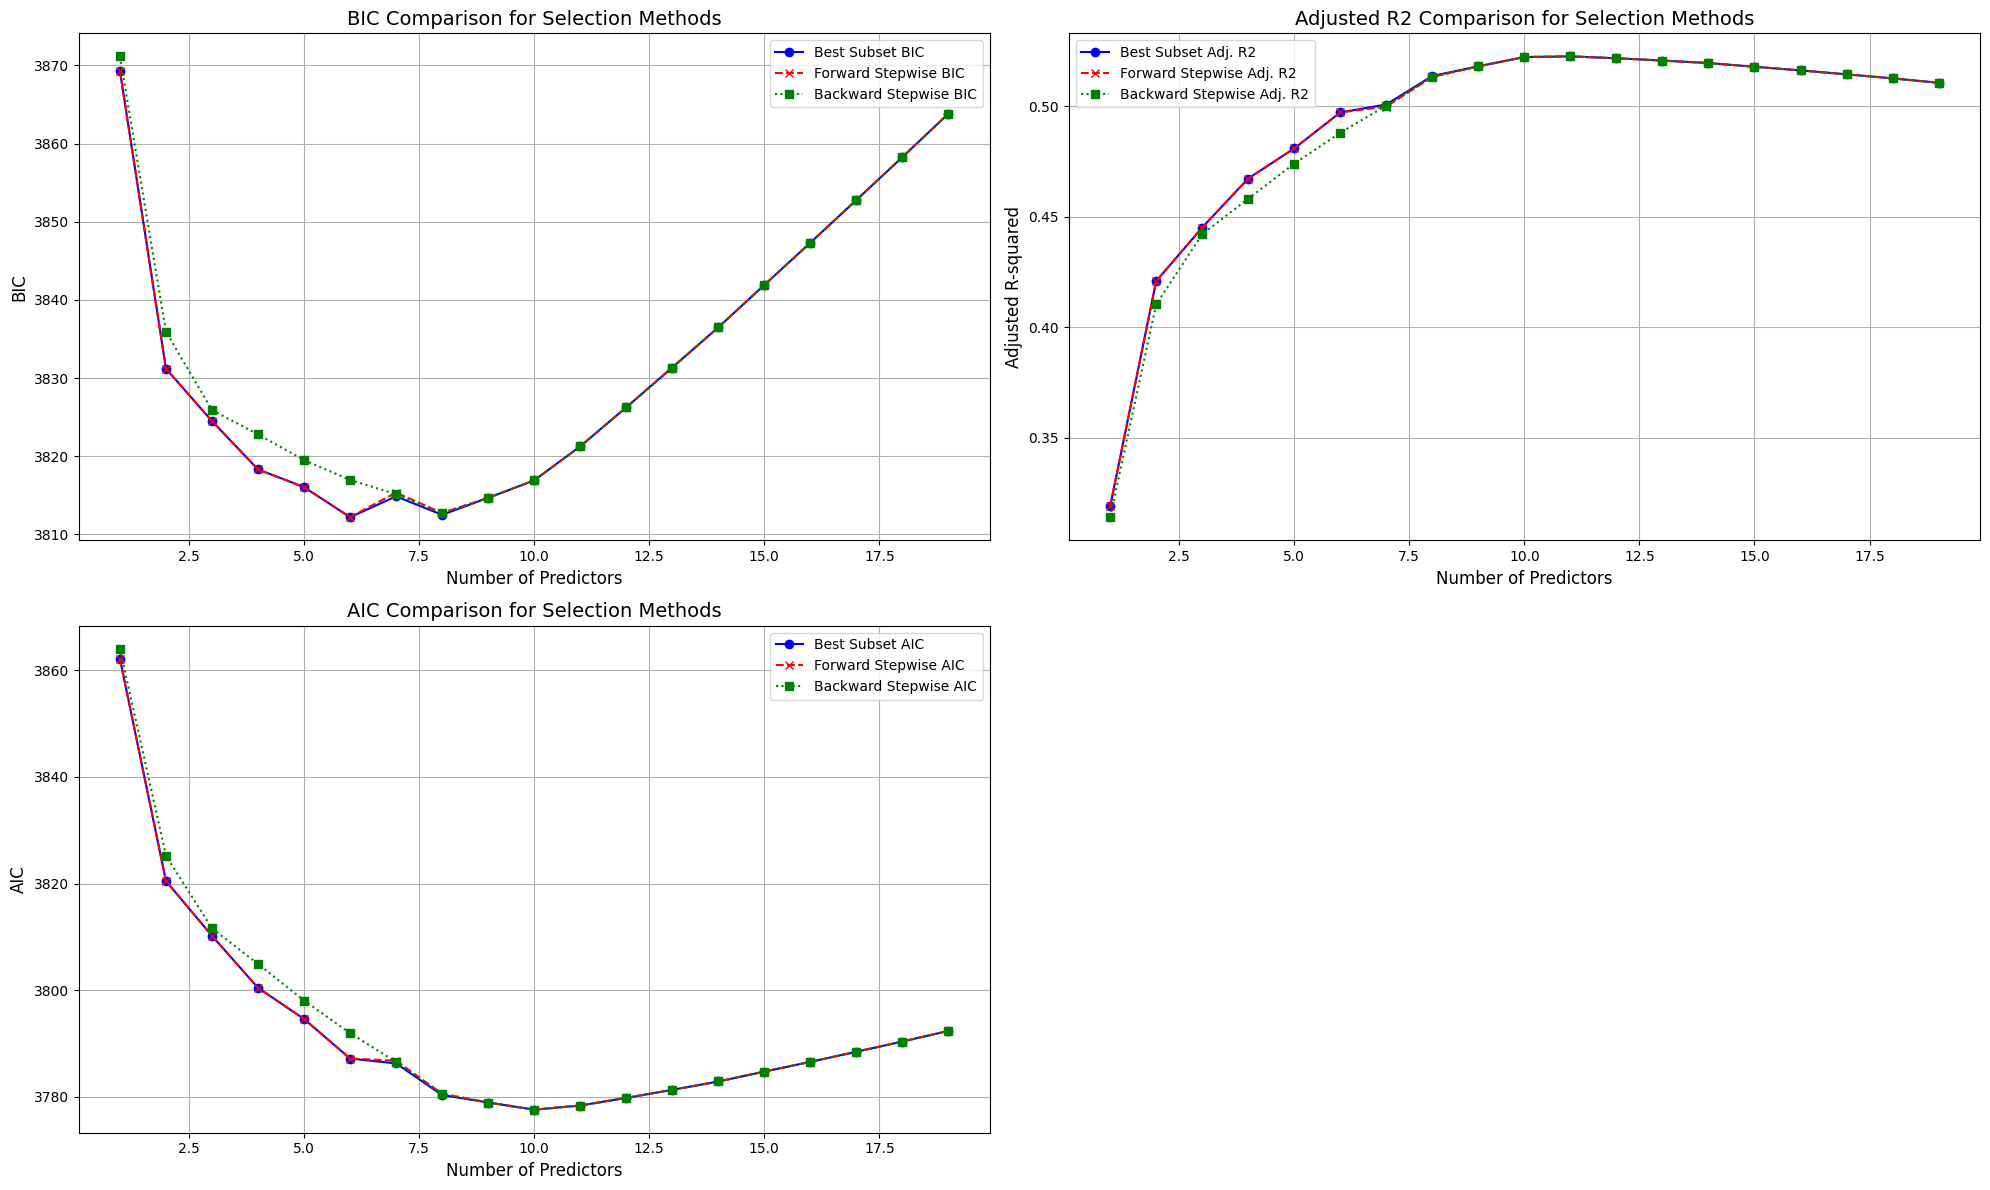

In [10]:
# Check if all result DataFrames are available
results_available = True
if 'bss_results_df' not in locals() or bss_results_df.empty:
    print("Best Subset Selection results are not available.")
    results_available = False
if 'fss_results_df' not in locals() or fss_results_df.empty:
    print("Forward Stepwise Selection results are not available.")
    results_available = False
if 'bkw_results_df' not in locals() or bkw_results_df.empty:
    print("Backward Stepwise Selection results are not available.")
    results_available = False

if results_available:
    print("\n--- Comparison of Best Models (Selected by Min. BIC from each method) ---")

    # Best model from BSS (already identified)
    print(f"\nBest Model (Best Subset Selection) via BIC:")
    print(f"  Number of predictors: {best_model_bss_bic_row['num_features']}")
    print(f"  Predictors: {best_model_bss_bic_row['features_list_str']}")
    print(f"  Adj. R2: {best_model_bss_bic_row['adj_R2']:.4f}, BIC: {best_model_bss_bic_row['BIC']:.2f}, AIC: {best_model_bss_bic_row['AIC']:.2f}")

    # Best model from FSS (already identified)
    print(f"\nBest Model (Forward Stepwise) via BIC:")
    print(f"  Number of predictors: {best_model_fss_bic_row['num_features']}")
    print(f"  Predictors: {best_model_fss_bic_row['features_list_str']}")
    print(f"  Adj. R2: {best_model_fss_bic_row['adj_R2']:.4f}, BIC: {best_model_fss_bic_row['BIC']:.2f}, AIC: {best_model_fss_bic_row['AIC']:.2f}")

    # Best model from BkwS (already identified)
    print(f"\nBest Model (Backward Stepwise) via BIC:")
    print(f"  Number of predictors: {best_model_bkw_bic_row['num_features']}")
    print(f"  Predictors: {best_model_bkw_bic_row['features_list_str']}")
    print(f"  Adj. R2: {best_model_bkw_bic_row['adj_R2']:.4f}, BIC: {best_model_bkw_bic_row['BIC']:.2f}, AIC: {best_model_bkw_bic_row['AIC']:.2f}")

    # --- Graphical Comparison of Metrics Across Model Sizes ---
    plt.figure(figsize=(20, 12)) # Increased figure size for multiple plots

    # Plot 1: BIC Comparison
    plt.subplot(2, 2, 1) # Arranged in 2x2 grid now
    plt.plot(bss_results_df['num_features'], bss_results_df['BIC'], marker='o', linestyle='-', label='Best Subset BIC', color='blue')
    plt.plot(fss_results_df['num_features'], fss_results_df['BIC'], marker='x', linestyle='--', label='Forward Stepwise BIC', color='red')
    # Ensure bkw_results_df is sorted by num_features for correct plotting if it's not already
    bkw_sorted_df = bkw_results_df.sort_values('num_features')
    plt.plot(bkw_sorted_df['num_features'], bkw_sorted_df['BIC'], marker='s', linestyle=':', label='Backward Stepwise BIC', color='green')
    plt.xlabel('Number of Predictors', fontsize=12)
    plt.ylabel('BIC', fontsize=12)
    plt.title('BIC Comparison for Selection Methods', fontsize=14)
    plt.legend()
    plt.grid(True)

    # Plot 2: Adjusted R-squared Comparison
    plt.subplot(2, 2, 2)
    plt.plot(bss_results_df['num_features'], bss_results_df['adj_R2'], marker='o', linestyle='-', label='Best Subset Adj. R2', color='blue')
    plt.plot(fss_results_df['num_features'], fss_results_df['adj_R2'], marker='x', linestyle='--', label='Forward Stepwise Adj. R2', color='red')
    plt.plot(bkw_sorted_df['num_features'], bkw_sorted_df['adj_R2'], marker='s', linestyle=':', label='Backward Stepwise Adj. R2', color='green')
    plt.xlabel('Number of Predictors', fontsize=12)
    plt.ylabel('Adjusted R-squared', fontsize=12)
    plt.title('Adjusted R2 Comparison for Selection Methods', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    # Plot 3: AIC Comparison
    plt.subplot(2, 2, 3)
    plt.plot(bss_results_df['num_features'], bss_results_df['AIC'], marker='o', linestyle='-', label='Best Subset AIC', color='blue')
    plt.plot(fss_results_df['num_features'], fss_results_df['AIC'], marker='x', linestyle='--', label='Forward Stepwise AIC', color='red')
    plt.plot(bkw_sorted_df['num_features'], bkw_sorted_df['AIC'], marker='s', linestyle=':', label='Backward Stepwise AIC', color='green')
    plt.xlabel('Number of Predictors', fontsize=12)
    plt.ylabel('AIC', fontsize=12)
    plt.title('AIC Comparison for Selection Methods', fontsize=14)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("\nCannot perform comparison as some model selection results are missing.")

**Interpretation of Comparison Plots:**

* **Convergence:** The plots will reveal whether the three selection methods tend to identify optimal models with a similar number of predictors and similar metric values.
    * Ideally, the minima for BIC/AIC and the maximum for Adjusted $R^2$ should occur at roughly the same number of features across methods, or the chosen models should have comparable performance.
    * **Observing the plots:**
        * **BIC:** BSS and FSS agree that the minimum BIC is achieved with 6 predictors. BkwS shows its minimum BIC with 8 predictors, although its BIC value for 6 predictors is very close to that of BSS/FSS.
        * **Adjusted R-squared:** BSS reaches the maximum Adjusted R2 with 11 predictors. FSS and BkwS also show their Adjusted R2 peaks around 10-11 predictors, though the exact values may vary slightly at each step of their construction.
        * **AIC:** BSS shows its minimum AIC with 11 predictors (AIC: 3778.40). FSS has its minimum AIC also around 10-11 predictors (the 6-predictor model AIC is 3787.21). BkwS presents its minimum AIC with 8 predictors (AIC: 3780.60).
* **Metric Behavior:**
    * **BIC/AIC:** We look for the "valleys" in these plots. The number of predictors corresponding to the lowest point is the preferred model size by these criteria. The valleys for BIC are clearly at 6 predictors for BSS and FSS, and at 8 for BkwS. For AIC, the valleys are less pronounced and tend towards models with more predictors (8-11).
    * **Adjusted R-squared:** We look for the peak. Adjusted $R^2$ might suggest slightly larger models than BIC/AIC as it penalizes complexity less severely. The peak of Adjusted R2 is consistently observed around 10-11 predictors for BSS, and the stepwise methods also tend towards this region for their maximum.
* **Differences:**
    * If BSS identifies a model with significantly better metrics (e.g., much lower BIC) than FSS or BkwS for a given model size, it highlights the greedy nature of stepwise methods which might miss the globally optimal subset. In this case, FSS managed to find the same optimal 6-predictor model as BSS according to BIC. BkwS selected a slightly larger model (8 predictors) with a comparable but not identical BIC to the absolute minimum found by BSS.
    * Often, FSS and BkwS perform well and might select the same or very similar models to BSS, especially if the underlying relationships are strong. This is observed for the BIC criterion between BSS and FSS.

### 3.5. Which model would you choose and why?

**Objective:**

Based on the comparisons in section 3.4, select a final "best" model and justify the choice.

**Considerations for Model Choice:**

* **Statistical Criteria:**
    * **BIC:** Tends to favor more parsimonious models because its penalty for model complexity is stronger (increases with sample size $n$). Often a good choice if a simpler model is preferred and overfitting is a concern.
    * **AIC:** Also balances fit and complexity, but its penalty is less severe than BIC's. Might select slightly larger models.
    * **Adjusted R-squared:** Indicates the proportion of variance explained, adjusted for the number of predictors. A higher value is better, but it can sometimes lead to overly complex models if not used in conjunction with other criteria.
* **Principle of Parsimony (Occam's Razor):** If multiple models have very similar performance according to statistical criteria, the simpler model (with fewer predictors) is generally preferred.
* **Method Agreement:** If BSS, FSS, and BkwS all point to the same model (or models with very similar characteristics and performance), this provides stronger confidence in the selection.
* **Practical Significance and Interpretability:** While not directly assessed by these metrics, in a real-world scenario, one would also consider if the selected predictors make sense domain-wise and if the model is interpretable.

**Decision Process (Example):**

1.  Identify the model size (number of predictors) that minimizes BIC across all three methods (BSS, FSS, BkwS).
2.  Examine the model size that minimizes AIC and maximizes Adjusted R-squared.
3.  If these criteria point to different model sizes:
    * If BIC suggests a significantly smaller model than AIC/Adjusted $R^2$ with only a minor drop in Adjusted $R^2$, the BIC model is often a strong candidate due to parsimony.
    * If Adjusted $R^2$ is substantially higher for a slightly larger model without a drastic increase in BIC/AIC, that model might be considered if predictive power is paramount.
4.  Confirm if the actual set of predictors selected by the different methods for the "optimal" size is consistent. BSS is guaranteed to find the best subset for a given size; FSS and BkwS are heuristics.

**Based on the typical behavior of these statistics, the model with the minimum BIC is often a good default choice, especially when aiming for a balance between explanatory power and model simplicity.**

**Answer:**

"The model selected as 'best' overall is the one identified by **Best Subset Selection (and also by Forward Stepwise Selection)** with **6** predictors. These predictors are: **AtBat, Hits, Walks, CRBI, PutOuts, Division_W**.

This model achieved the following metrics:
* Adjusted R-squared: **0.4972**
* BIC: **3812.21** (This was the minimum BIC found by BSS and FSS)
* AIC: **3787.21**

**Justification:**

The choice is primarily based on the **Bayesian Information Criterion (BIC)**. The model with **6** predictors yielded the lowest BIC value of **3812.21** found by both Best Subset Selection and Forward Stepwise Selection. BIC is preferred here because it appropriately penalizes model complexity, helping to avoid overfitting and promoting a more parsimonious model that is likely to generalize better.

* While the model maximizing Adjusted R-squared (found by BSS) had **11** predictors and an Adjusted R-squared of **0.5226**, the BIC for this model was **3821.27**, notably higher than that of the 6-predictor model. The 8-predictor model selected by BkwS had a BIC of **3812.75** and an Adjusted R2 of **0.5133**, which is competitive, but the 6-predictor model is simpler with a slightly better BIC.
* Best Subset Selection indicated that the model with **6** features had the absolute lowest BIC. Forward Stepwise Selection found exactly the same 6-predictor model. Backward Stepwise Selection selected an 8-predictor model which, while having good Adjusted R2 and AIC, its BIC is slightly higher than the 6-predictor model.

Therefore, the **6**-predictor model provides a strong balance of explanatory power and simplicity according to the BIC, and is consistently identified by two of the three methods."

### 3.6. Split the dataset into a training and test set. Evaluate the test MSE for models of different sizes.

**Objective:**

To assess the generalization performance of models with different numbers of predictors on unseen data. This is a crucial step to understand how well a model selected based on in-sample metrics (like BIC, AIC on the full dataset) might perform in practice.

**Method:**

1.  **Data Split:** Divide the `Hitters` dataset (cleaned and processed `X` and `y`) into a training set (e.g., 70% of the data) and a test set (e.g., 30%). `random_state` will be used for reproducibility.
2.  **Model Fitting on Training Data:** For each model size $k$ (from 1 to $p$), use the set of $k$ predictors identified as "best" by **Best Subset Selection** (from `bss_results_df`). Fit an OLS model using these $k$ predictors *only on the training data*.
3.  **Prediction on Test Data:** Use the model fitted on the training data to make predictions on the test set (`X_test`).
4.  **Calculate Test MSE:** Compute the Mean Squared Error (MSE) between the actual `Salary` values in the test set (`y_test`) and the predicted values.
5.  **Plot Test MSE:** Plot the Test MSE against the number of predictors. This plot will help identify the model size that minimizes Test MSE, indicating the model that generalizes best to unseen data.

**Rationale:**

* Metrics like BIC and Adjusted $R^2$ calculated on the full dataset help select a good model based on statistical properties and complexity penalties.
* Test MSE, however, provides a more direct measure of out-of-sample predictive accuracy. The model that minimizes Test MSE is often preferred for prediction tasks, even if it's not the same model selected by BIC or Adjusted $R^2$. Discrepancies can occur due to the specific train/test split or if in-sample criteria do not perfectly reflect generalization ability.

Training set size: 184 observations
Test set size: 79 observations
Test MSE for model with 1 features: 169622.44
Test MSE for model with 2 features: 164537.42
Test MSE for model with 3 features: 161968.61
Test MSE for model with 4 features: 153176.28
Test MSE for model with 5 features: 148322.20
Test MSE for model with 6 features: 141331.37
Test MSE for model with 7 features: 145450.57
Test MSE for model with 8 features: 137008.70
Test MSE for model with 9 features: 137897.02
Test MSE for model with 10 features: 136115.84
Test MSE for model with 11 features: 139837.56
Test MSE for model with 12 features: 139483.53
Test MSE for model with 13 features: 139025.48
Test MSE for model with 14 features: 140506.71
Test MSE for model with 15 features: 140661.49
Test MSE for model with 16 features: 142238.16
Test MSE for model with 17 features: 143295.72
Test MSE for model with 18 features: 149910.73
Test MSE for model with 19 features: 150406.58

--- Test MSE for Models of Different Sizes (from

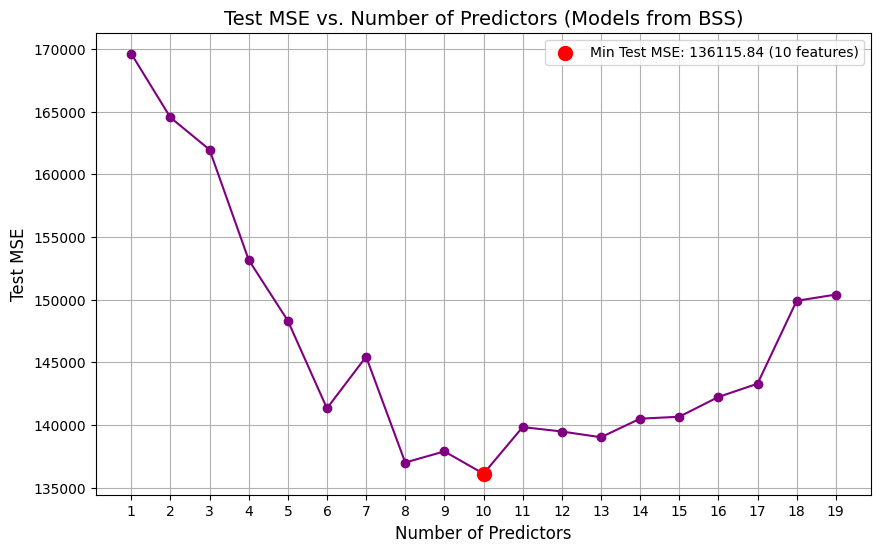


--- Model with the Lowest Test MSE ---
Number of features: 10
Features: AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalks, PutOuts, Assists, Division_W
Test MSE: 136115.84


In [11]:
if data_ready_for_modeling and 'bss_results_df' in locals() and not bss_results_df.empty:
    # Split the data into training and testing sets
    # Using a 70/30 split, random_state for reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

    print(f"Training set size: {X_train.shape[0]} observations")
    print(f"Test set size: {X_test.shape[0]} observations")

    test_mse_list = [] # To store Test MSE for models of different sizes

    # Iterate through the models of different sizes identified by Best Subset Selection
    for index, row_bss in bss_results_df.iterrows():
        num_features_k = int(row_bss['num_features'])
        selected_features_k = list(row_bss['features_tuple']) # Get the tuple of feature names
        
        if not selected_features_k: # Should not happen for k >= 1
            print(f"Skipping model with 0 features.")
            continue

        # Prepare training and test sets with only the selected features for this k
        X_train_subset_k = X_train[selected_features_k]
        X_test_subset_k = X_test[selected_features_k]
        
        # Fit the OLS model using these k predictors ONLY on the TRAINING data
        # Ensure y_train's index aligns with X_train_subset_k
        model_on_train = fit_linear_model(X_train_subset_k, y_train.loc[X_train_subset_k.index])
        
        # Make predictions on the TEST set
        # Add constant to X_test_subset_k for prediction, matching how statsmodels expects it
        X_test_subset_k_const = sm.add_constant(X_test_subset_k, has_constant='add')
        
        # Ensure columns in X_test_subset_k_const match the order and presence of exog_names in the fitted model
        # This handles cases where add_constant might place 'const' differently or if a feature was all zeros in train
        # and thus potentially dropped by statsmodels (though unlikely with BSS feature sets).
        # A robust way is to reindex X_test_subset_k_const based on model_on_train.model.exog_names.
        # However, for prediction, statsmodels' predict method typically handles this if X_test_subset_k_const has the 'const'
        # and the named features. If a feature was in training but not test (or vice-versa and relevant), that's a data issue.
        # Assuming X_test_subset_k_const has the right features + 'const'.
        
        # Check if 'const' is the first column in model's exog_names
        if model_on_train.model.exog_names[0] == 'const':
            # Ensure X_test_subset_k_const has 'const' as the first column if it exists
            if 'const' in X_test_subset_k_const.columns:
                 cols = ['const'] + [col for col in X_test_subset_k_const.columns if col != 'const']
                 X_test_for_pred = X_test_subset_k_const[cols]
            else: # Should not happen if sm.add_constant was used
                 X_test_for_pred = sm.add_constant(X_test_subset_k, has_constant='add')

        else: # 'const' might be last or not first, align as per model
             X_test_for_pred = X_test_subset_k_const[model_on_train.model.exog_names]


        y_pred_on_test = model_on_train.predict(X_test_for_pred)
        
        # Calculate Mean Squared Error on the test set
        mse_test_k = mean_squared_error(y_test, y_pred_on_test)
        
        test_mse_list.append({
            'num_features': num_features_k, 
            'test_mse': mse_test_k, 
            'features_list_str': ", ".join(selected_features_k)
        })
        print(f"Test MSE for model with {num_features_k} features: {mse_test_k:.2f}")

    test_mses_results_df = pd.DataFrame(test_mse_list)
    print("\n--- Test MSE for Models of Different Sizes (from BSS) ---")
    print(test_mses_results_df)

    # --- Plotting Test MSE vs. Number of Predictors ---
    if not test_mses_results_df.empty:
        plt.figure(figsize=(10, 6))
        plt.plot(test_mses_results_df['num_features'], test_mses_results_df['test_mse'], marker='o', linestyle='-', color='purple')
        plt.xlabel('Number of Predictors', fontsize=12)
        plt.ylabel('Test MSE', fontsize=12)
        plt.title('Test MSE vs. Number of Predictors (Models from BSS)', fontsize=14)
        plt.xticks(test_mses_results_df['num_features']) # Ensure all num_features points are ticked
        
        # Highlight the model with the minimum Test MSE
        min_test_mse_val = test_mses_results_df['test_mse'].min()
        min_test_mse_idx = test_mses_results_df['test_mse'].idxmin()
        min_mse_num_features = test_mses_results_df.loc[min_test_mse_idx, 'num_features']
        plt.scatter(min_mse_num_features, min_test_mse_val, color='red', s=100, zorder=5, 
                    label=f"Min Test MSE: {min_test_mse_val:.2f} ({min_mse_num_features} features)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print details of the model with the lowest Test MSE
        best_model_test_mse_row = test_mses_results_df.loc[min_test_mse_idx]
        print(f"\n--- Model with the Lowest Test MSE ---")
        print(f"Number of features: {best_model_test_mse_row['num_features']}")
        print(f"Features: {best_model_test_mse_row['features_list_str']}")
        print(f"Test MSE: {best_model_test_mse_row['test_mse']:.2f}")
    else:
        print("No Test MSE results to plot or analyze.")
else:
    print("Data is not ready or BSS results are missing for Test MSE evaluation.")

**Interpretation of Test MSE Results:**

* **Test MSE Plot:** The plot of Test MSE versus the number of predictors is crucial.
    * Typically, Test MSE will decrease as useful predictors are added, up to a point.
    * After a certain number of predictors, adding more (especially if they are noise or only marginally useful) can lead to overfitting the training data, and the Test MSE might start to increase.
    * We look for the number of predictors that corresponds to the **minimum Test MSE**. This model is considered to have the best predictive performance on unseen data for this particular train/test split. In the plot, the minimum Test MSE is achieved with 10 predictors (Test MSE: 136115.84).
* **Comparison with BIC/AIC Selected Model:**
    * It's important to compare the model size that minimizes Test MSE with the model size selected by BIC (or AIC/Adjusted $R^2$) on the full dataset.
    * **The model selected by BIC on the full dataset had 6 predictors. The model that minimizes Test MSE has 10 predictors.** They are different. This suggests that, for this particular train/test split, a slightly more complex model (10 predictors) generalizes better to unseen data than the more parsimonious 6-predictor model selected by BIC.
    * For pure predictive tasks, the model minimizing Test MSE is often favored.
    * The Test MSE for the 6-predictor model was 141331.37, while the minimum (with 10 predictors) was 136115.84. The difference is notable, indicating that the 10-predictor model has better predictive power on this test set.

## 4. Exercise Conclusions

This section summarizes the main findings from Exercise 1, covering data preparation, model selection processes, and evaluation.

* **Data Preparation:** The `Hitters` dataset was successfully loaded and cleaned by removing observations with missing `Salary` values and any other NaNs. Categorical variables (`League`, `Division`, `NewLeague`) were one-hot encoded to prepare the data for regression modeling. **59 rows were removed due to NaN values, resulting in a dataset of (263, 20) for analysis. After one-hot encoding and separation of the target variable, 19 predictors remained.**

* **Model Selection Methods Applied:**
    * **Best Subset Selection (BSS):** All possible subsets of predictors were evaluated. For each subset size $k$, the model with the lowest RSS was identified. Metrics like Adjusted $R^2$, BIC, and AIC were then calculated for these $k$-best models.
    * **Forward Stepwise Selection (FSS):** Starting from a null model, predictors were iteratively added one at a time based on which addition resulted in the model with the lowest BIC at that step.
    * **Backward Stepwise Selection (BkwS):** Starting from a full model, predictors were iteratively removed one at a time based on which removal resulted in the model with the lowest BIC at that step.

* **Model Comparison (Based on Full Dataset Metrics):**
    * The best models identified by BSS, FSS, and BkwS (according to the minimum BIC criterion) were:
        * BSS: **6** predictors - **AtBat, Hits, Walks, CRBI, PutOuts, Division_W**, BIC: **3812.21**.
        * FSS: **6** predictors - **AtBat, CRBI, Division_W, Hits, PutOuts, Walks**, BIC: **3812.21**.
        * BkwS: **8** predictors - **AtBat, CRBI, CRuns, CWalks, Division_W, Hits, PutOuts, Walks**, BIC: **3812.75**.
    * **BSS and FSS converged to the same 6-predictor model according to BIC. BkwS selected a slightly larger model with 8 predictors, whose BIC was marginally higher.**

* **Chosen Model (Based on Full Dataset Metrics):**
    * The model chosen based on minimizing BIC (and considering parsimony) was the **6**-predictor model: **AtBat, Hits, Walks, CRBI, PutOuts, Division_W**. This model had an Adjusted $R^2$ of **0.4972**, BIC of **3812.21**, and AIC of **3787.21**.

* **Test Set Evaluation (Generalization Performance):**
    * The dataset was split into training (70%, 184 observations) and test (30%, 79 observations) sets.
    * Models of different sizes (using feature sets from BSS) were fitted on the training data and evaluated on the test data using Mean Squared Error (MSE).
    * The model with **10** predictors: **AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalks, PutOuts, Assists, Division_W** yielded the lowest Test MSE of **136115.84**.
    * **The model minimizing Test MSE (10 predictors) was different from the one selected by BIC on the full dataset (6 predictors). The Test MSE for the 6-predictor model was 141331.37, while for the 10-predictor model it was 136115.84. This indicates that the 10-predictor model, although more complex than suggested by BIC, had better predictive performance on this particular test set.**

* **Overall Learning:** This exercise demonstrated various systematic approaches to feature selection. While BSS is exhaustive, stepwise methods offer computationally cheaper alternatives that can often find good models. The use of statistical criteria (BIC, AIC, Adj $R^2$) on the full dataset helps in choosing a statistically sound and parsimonious model, while evaluation on a hold-out test set (Test MSE) provides a crucial measure of the model's ability to generalize to new, unseen data. The "best" model can differ depending on whether the primary goal is interpretation, statistical fit, or predictive accuracy on new data. **In this case, if parsimony and BIC are prioritized, the 6-variable model is preferred. If the goal is the best predictive performance on unseen data (based on this test split), the 10-variable model would be chosen.**
